In [1]:
from itertools import cycle
import matplotlib.pyplot as plt
from numpy import interp
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
import os
import xgboost as xgb
from sklearn.preprocessing import label_binarize

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

D:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def plotROC(n_classes,y_test,y_score):
    # 计算每一类的ROC
    y_test = label_binarize(y_test, classes=[0, 1, 2])

    y_score = np.array(y_score)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area（方法二）
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area（方法一）
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw = 2
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.3f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.3f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.3f})'
                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

# 计算准确率
def calculate_all_prediction(confMatrix):
    '''
    计算总精度,对角线上所有值除以总数
    :return:
    '''
    total_sum = confMatrix.sum()
    correct_sum = (np.diag(confMatrix)).sum()
    prediction = round(100 * float(correct_sum) / float(total_sum), 2)
    print('准确率:' + str(prediction) + '%')


def calculae_lable_prediction(confMatrix):
    '''
    计算每一个类别的预测精度:该类被预测正确的数除以该类的总数
    '''
    l = len(confMatrix)
    for i in range(l):
        label_total_sum = confMatrix.sum(axis=1)[i]
        label_correct_sum = confMatrix[i][i]
        prediction = round(100 * float(label_correct_sum) / float(label_total_sum), 2)
        print('精确率: {0} : {1} %'.format(i, prediction))

def calculate_label_recall(confMatrix):
    l = len(confMatrix)
    for i in range(l):
        label_total_sum = confMatrix.sum(axis=0)[i]
        label_correct_sum = confMatrix[i][i]
        prediction = round(100 * float(label_correct_sum) / float(label_total_sum), 2)
        print('召回率: {0} : {1} %'.format(i, prediction))

In [3]:
file = '代谢组数据 - 填充 by min - 副本.csv'
df = pd.read_csv(file,engine='python')
features=df.columns.tolist()

feat_labels = df.columns[5:]
X=df[features[5:]]
y=df[features[4]]

pd.DataFrame(X)
pd.DataFrame(y)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

XGB结果

In [4]:
model = xgb.XGBClassifier( learning_rate =0.1,
 n_estimators=200,
 max_depth=5)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # 下标排序
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.predict_proba(X_test)


特征排序结果——————————————————————————————————————————————————
 1) 3-Hydroxybutyric acid          0.071993
 2) Putrescine                     0.057618
 3) LPG(16:0)                      0.055684
 4) PG(16:0_20:4)                  0.045701
 5) 3-Methoxytyrosine              0.044129
 6) 7-Methylxanthine               0.037135
 7) Ascorbate                      0.036927
 8) Dopamine 4-o-sulfate           0.028962
 9) LPC(26:1)                      0.027577
10) DG(18:0_22:6)                  0.026376
11) 1-Methylxanthine               0.021297
12) PE(40:4)                       0.020687
13) Erythose 4-phosphate           0.019695
14) HexCer(d18:1/18:0)             0.019363
15) Cer(d18:1/16:0)                0.018883
16) Histamine                      0.017643
17) (3-O-sulfo)GalCer(d18:1/18:0(2OH) 0.013662
18) PE(36:1)                       0.013145
19) Dopamine 3-o-sulfate           0.011629
20) LPI(16:0)                      0.010786
21) CE(16:1)                       0.009542
22) PG(18:0_18:1

In [5]:
y_score

array([[2.89448712e-04, 2.58733693e-04, 9.99451816e-01],
       [9.55733776e-01, 5.88661386e-03, 3.83795947e-02],
       [3.40776867e-04, 2.24753679e-03, 9.97411668e-01],
       [3.51382270e-02, 8.38020165e-03, 9.56481516e-01],
       [9.98133719e-01, 7.86150049e-04, 1.08011963e-03],
       [2.12719664e-03, 6.28912123e-04, 9.97243881e-01],
       [9.70763385e-01, 2.09615994e-02, 8.27499945e-03],
       [7.72230444e-04, 1.38470007e-03, 9.97843027e-01],
       [9.88501668e-01, 4.41304903e-04, 1.10569922e-02],
       [1.80340270e-04, 5.45698451e-04, 9.99273956e-01],
       [9.91917431e-01, 2.15274235e-03, 5.92983654e-03],
       [1.14164362e-03, 3.39478930e-03, 9.95463550e-01],
       [1.13849400e-03, 4.27837530e-03, 9.94583189e-01],
       [1.72427774e-03, 9.95020866e-01, 3.25483875e-03],
       [9.99105632e-01, 2.77362880e-04, 6.16975361e-04],
       [5.70690841e-04, 6.00344152e-04, 9.98828948e-01],
       [4.09227088e-02, 7.85446286e-01, 1.73631027e-01],
       [1.80110231e-03, 4.56284

In [6]:
Y_test

473    2
485    0
466    2
359    2
583    0
      ..
484    0
537    0
358    2
406    2
540    0
Name: COHORT-ID, Length: 122, dtype: int64

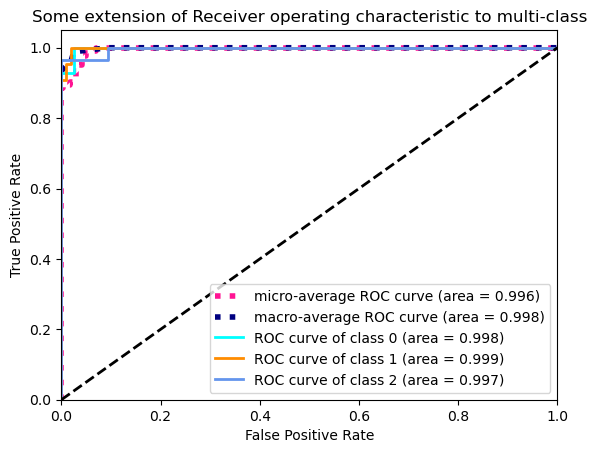

交叉验证得分：
[0.95918367 0.89795918 0.97959184 0.95918367 0.89795918 0.97916667
 0.91666667 0.9375     0.91666667 0.9375    ]
0.9381377551020409


In [7]:
plotROC(3,Y_test,y_score)

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())

RF结果

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      |

特征排序结果——————————————————————————————————————————————————
 1) Putrescine                     0.117266
 2) PG(16:0_20:4)                  0.065971
 3) 3-Methoxytyrosine              0.061570
 4) Dopamine 4-o-sulfate           0.059000
 5) Ascorbate                      0.055389
 6) Dopamine 3-o-sulfate           0.044634
 7) Dopa                           0.028521
 8) LPG(16:0)                      0.020794
 9) LPC(26:1)                      0.018252
10) PA(18:1/18:1)                  0.014146
11) 3-Hydroxybutyric acid          0.013659
12) Oxoglutaric acid               0.013388
13) Aspartic acid                  0.013331
14) 3-Hydroxy-N6,N6,N6-Trimethyllysine 0.012435
15) LPG(18:0)                      0.010353
16) MG(18:0)                       0.009952
17) Erythose 4-phosphate           0.009175
18) Glutathione                    0.007179
19) 7-Methylxanthine               0.006026
20) Histamine                      0.005928
21) Piperine                       0.004767
22) Paraxanthin

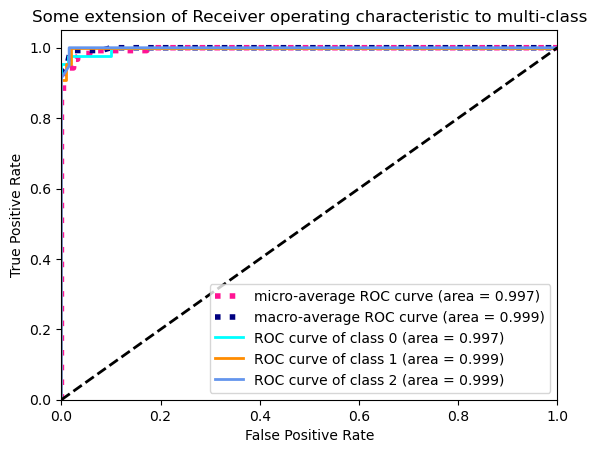

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 174 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 200

交叉验证得分：
[0.89795918 0.91836735 0.97959184 0.95918367 0.89795918 0.875
 0.95833333 0.95833333 0.91666667 0.95833333]
0.9319727891156463


[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished


In [8]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(criterion='gini',max_features=25,n_estimators=200,random_state=1,n_jobs=2,verbose=1)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # 下标排序
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.predict_proba(X_test)
plotROC(3,Y_test,y_score)

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())

SVM

特征排序结果——————————————————————————————————————————————————
(238,)
(238,)
 1) Dopamine 3-o-sulfate           5.135444
 2) 3-Methoxytyrosine              4.881528
 3) Oxoglutaric acid               3.522923
 4) PI(16:0_18:1)                  3.100910
 5) Dopamine 4-o-sulfate           2.733607
 6) Piperine                       2.671321
 7) LPC(16:1)                      2.669955
 8) PE(38:5)                       2.598402
 9) DG(16:0_20:4)                  2.555254
10) (3-O-sulfo)GalCer(d18:1/24:0(2OH)) 2.552045
11) 1-Methylhistidine              2.474648
12) Uridine                        2.457775
13) PE(34:1)                       2.244810
14) PC(36:1)                       2.244305
15) Putrescine                     2.131771
16) Pyridoxamine                   2.057409
17) Cer(d18:1/18:0)                2.019506
18) 7-keto-Cholesterol             2.006661
19) LPC(18:0)                      1.934429
20) PC(40:5)                       1.921470
21) TG(20:4_32:1)                  1.914143
2

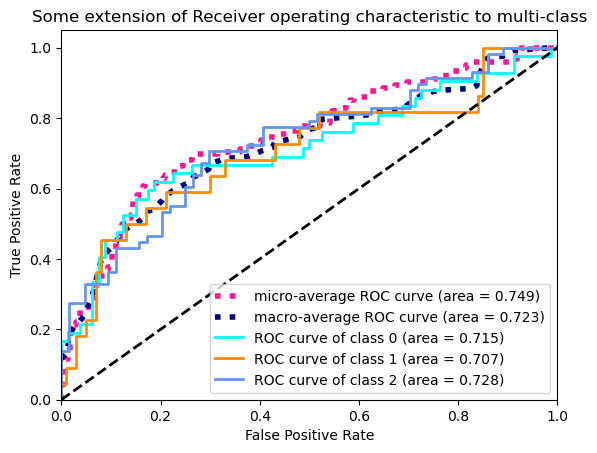

交叉验证得分：
[0.51020408 0.55102041 0.65306122 0.55102041 0.3877551  0.625
 0.54166667 0.60416667 0.58333333 0.52083333]
0.5528061224489795


In [9]:
from sklearn import svm
model = svm.SVC(kernel = 'linear')
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
coef = model.coef_
coef = np.abs(coef)
importances = np.sum(coef, axis=0)
indices = np.argsort(importances)[::-1] # 下标排序
print(importances.shape)
print(indices.shape)
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.decision_function(X_test)
plotROC(3,Y_test,y_score)

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())

Cart

特征排序结果——————————————————————————————————————————————————
 1) Putrescine                     0.614808
 2) 3-Methoxytyrosine              0.120734
 3) Dopamine 4-o-sulfate           0.069186
 4) MG(18:0)                       0.052938
 5) PG(16:0_20:4)                  0.043971
 6) Paraxanthine                   0.025178
 7) Xanthosine                     0.020861
 8) TG(20:4_36:3)                  0.019010
 9) 7-keto-Cholesterol             0.018521
10) LPG(18:1)                      0.014792
11) Erythose 4-phosphate           0.000000
12) Cer(d18:1/16:0)                0.000000
13) DG(18:0_18:1)                  0.000000
14) DG(16:0_20:4)                  0.000000
15) DG(16:0_18:1)                  0.000000
16) Coenzyme Q10                   0.000000
17) Cholesteryl hexoside           0.000000
18) Cer(d18:1/24:1)                0.000000
19) Cer(d18:1/24:0)                0.000000
20) cis-Aconitic acid              0.000000
21) Cer(d18:1/18:0)                0.000000
22) CE(22:6)       

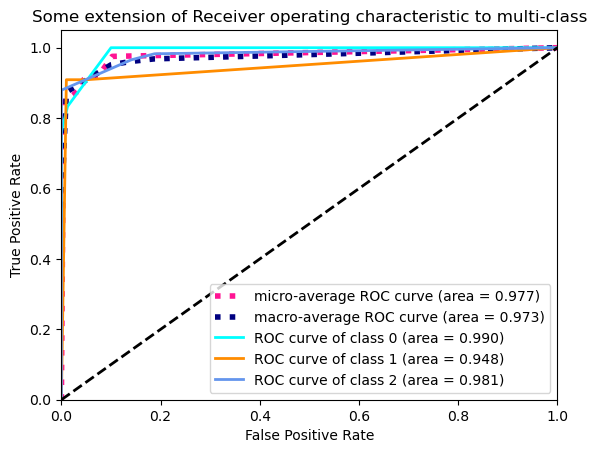

交叉验证得分：
[0.93877551 0.89795918 0.95918367 0.91836735 0.87755102 0.91666667
 0.89583333 0.9375     0.91666667 0.89583333]
0.9154336734693878


In [10]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=42)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # 下标排序
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.predict_proba(X_test)
plotROC(3,Y_test,y_score)

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())

GBM

特征排序结果——————————————————————————————————————————————————
 1) Putrescine                     0.271281
 2) PG(16:0_20:4)                  0.132279
 3) Dopamine 4-o-sulfate           0.126572
 4) 3-Methoxytyrosine              0.090705
 5) Ascorbate                      0.072388
 6) LPG(16:0)                      0.054682
 7) 3-Hydroxybutyric acid          0.046292
 8) 7-Methylxanthine               0.024862
 9) N-Alpha-acetyllysine           0.016314
10) LPC(26:1)                      0.011941
11) Erythose 4-phosphate           0.011820
12) 1-Methylxanthine               0.009052
13) Dopamine 3-o-sulfate           0.008926
14) Histamine                      0.008173
15) Glutathione                    0.006621
16) CE(18:1)                       0.005407
17) Oxalacetic acid                0.005153
18) BMP(22:6/22:6)                 0.004594
19) Cholesterol sulfate            0.004494
20) 3-Hydroxykynurenine            0.004330
21) LPG(18:0)                      0.003818
22) Cystine        

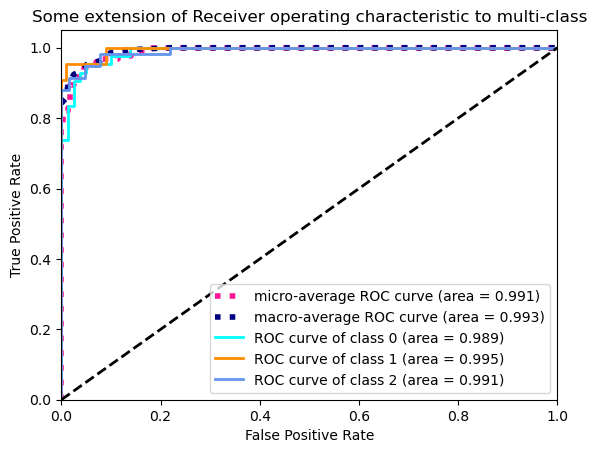

交叉验证得分：
[0.91836735 0.89795918 1.         0.95918367 0.93877551 1.
 0.95833333 0.9375     0.875      0.9375    ]
0.9422619047619047


In [11]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=10, random_state=42)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # 下标排序
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.predict_proba(X_test)
plotROC(3,Y_test,y_score)

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())

逻辑回归

特征排序结果——————————————————————————————————————————————————
(238,)
(238,)
 1) Threonine                      0.126303
 2) Cer(d18:1/24:1)                0.086409
 3) LPC(16:0)                      0.083767
 4) Cholesterol sulfate            0.071803
 5) Palmitoleic acid               0.067938
 6) Trigonelline                   0.061975
 7) Cer(d18:1/24:0)                0.056944
 8) Lactic acid                    0.056113
 9) DG(18:1/18:1)                  0.055340
10) PI(18:0_20:4)                  0.051727
11) PE(36:2)                       0.049608
12) DG(18:0_22:6)                  0.049163
13) PE(P-16:0/20:4)                0.041659
14) TG(18:1_34:2)                  0.040245
15) PE(P-18:0/20:4)                0.038167
16) SM(d18:1/16:0)                 0.037875
17) Dopamine 3-o-sulfate           0.036362
18) CE(16:1)                       0.036200
19) TG(18:1_34:3)                  0.033401
20) PE(P-18:1/20:4)                0.029836
21) SM(d18:1/18:0)                 0.028941
22) 1

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


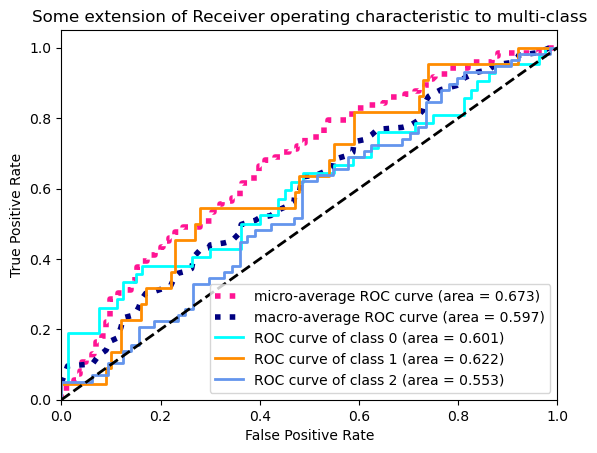

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

交叉验证得分：
[0.55102041 0.44897959 0.46938776 0.48979592 0.40816327 0.54166667
 0.39583333 0.41666667 0.47916667 0.47916667]
0.46798469387755104


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

In [12]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
coef = model.coef_
coef = np.abs(coef)
importances = np.sum(coef, axis=0)
indices = np.argsort(importances)[::-1] # 下标排序
print(importances.shape)
print(indices.shape)
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.decision_function(X_test)
plotROC(3,Y_test,y_score)

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())